# scikit-FIBERS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-FIBERS.

## Installation:

In [1]:
#Add Installation code

## Imports:

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
#from paretoset import paretoset
from sklearn.metrics import classification_report
from src.skfibers.fibers import FIBERS
from src.skfibers.experiments.datagen import create_data_simulation_bin
from src.skfibers.experiments.datagen_evolvable_threshold import create_data_simulation_bin_evolve

current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\ryanu\OneDrive\Documents\GitHub\scikit-FIBERS


## Survial Data Simulation

In [3]:
data = create_data_simulation_bin_evolve(number_of_instances=10000, number_of_features=100, number_of_features_in_bin=10,
                                  no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.0,
                                  class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                                  censoring_frequency=0.5, random_seed=42, negative=False, threshold=0)
data.to_csv('sampledata.csv', index=False)
data = pd.read_csv('sampledata.csv')
true_risk_group = data[['TrueRiskGroup']]
data = data.drop('TrueRiskGroup', axis=1)

## Running FIBERS (Training)

In [4]:
fibers = FIBERS(outcome_label="Duration", outcome_type="survival", iterations=50, pop_size = 50, crossover_prob=0.5, mutation_prob=0.1, 
                new_gen=1.0, elitism=0.1, min_bin_size=1, fitness_metric="log_rank", log_rank_weighting=None,
                censor_label="Censoring", group_strata_min=0.2, group_thresh=None, min_thresh=0, max_thresh=3, int_thresh=True, thresh_evolve_prob=0.5,
                manual_bin_init=None, covariates=None, report=None, random_seed=None, verbose=False)

fibers = fibers.fit(data)

Beginning FIBERS Fit:


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]

Random Seed Check - End: 0.330088906512752
FIBERS Run Complete!
Elapsed Time (sec):  93.78625273704529 seconds


## Top-Bin Examination

### 

In [5]:
bin_index = 0 # lowest index is the bin with the highest fitness (only reports the bin ranked at the top, despite possible fitness ties for top)
# Get bin reportting variables 
low_outcome, high_outcome, low_censor, high_censor, bin_report_df = fibers.get_bin_groups(data, bin_index)
print(bin_report_df)

                                                                   0
Features in Bin:           [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]
Threshold:                                                         1
Fitness:                                                  5497.67814
Metric Score:                                             5497.67814
p-value:                                                         0.0
Bin Size:                                                          8
Group Ratio:                                                     0.5
Count At/Below Threshold:                                       5000
Count Above Threshold:                                          5000
Birth Iteration:                                                  47


### Kaplan Meier Survival Plot (For Top Bin)

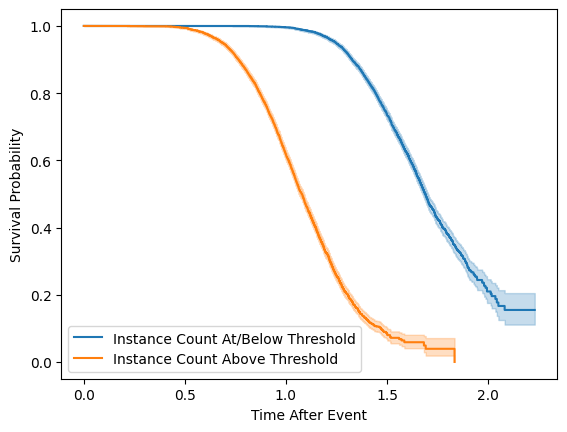

In [6]:
kmf1 = KaplanMeierFitter()

# fit the model for 1st cohort
kmf1.fit(low_outcome, low_censor, label='Instance Count At/Below Threshold')
a1 = kmf1.plot_survival_function()
a1.set_ylabel('Survival Probability')

# fit the model for 2nd cohort
kmf1.fit(high_outcome, high_censor, label='Instance Count Above Threshold')
kmf1.plot_survival_function(ax=a1)
a1.set_xlabel('Time After Event')

plt.show()

### Check and View Top Bin Ties

### 

In [7]:
top_bin_list = fibers.get_top_bins()
count = len(top_bin_list)
if count > 1:
    print(str(len(top_bin_list))+" bins were tied for best fitness")
    for bin in top_bin_list:
        #print("Features in Bin: "+str(bin.feature_list))
        report = bin.bin_short_report()
        print(report)
else:
    print("Only one top performing bin found")


25 bins were tied for best fitness
                                                          0
Features in Bin:  [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]
Threshold:                                                1
Fitness:                                         5497.67814
Bin Size:                                                 8
Group Ratio:                                            0.5
Birth Iteration:                                         47
                                                          0
Features in Bin:  [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]
Threshold:                                                0
Fitness:                                         5497.67814
Bin Size:                                                 8
Group Ratio:                                            0.5
Birth Iteration:                                         48
                                                                  0
Features in Bin:  [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_

## History of Bin Evolution
### Plot: Fitness of top bin each training iteration

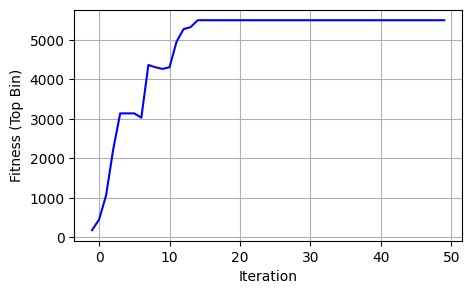

In [8]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Fitness']]

# Plot the data
plt.figure(figsize=(5, 3))
colors = ['blue']  # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Fitness (Top Bin)')
#plt.title('Top Bin Fitness Across Training Iterations')

# Show the plot
plt.grid(True)
plt.show()

### Plot: Normalized Top-Bin Stats Across Training Iterations

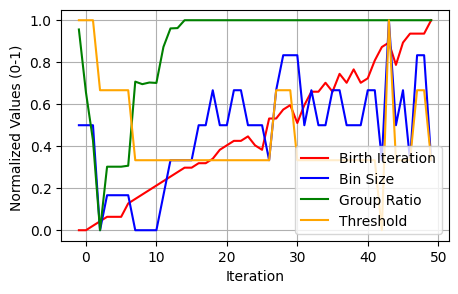

In [9]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Birth Iteration','Bin Size','Group Ratio','Threshold']]
df = (df - df.min()) / (df.max() - df.min())
# Plot the data
plt.figure(figsize=(5, 3))
colors = ['red', 'blue', 'green', 'orange']   # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Normalized Values (0-1) ')
#plt.title('Normalized Top-Bin Stats Across Training Iterations')
plt.legend()  # Show legend

# Show the plot
plt.grid(True)
plt.show()

### View: The dataframe containing all top-bin statistics/characteristics across training iterations

In [10]:
print(fibers.top_perform_df)

    Iteration                                            Top Bin  Threshold  \
0          -1  [R_76, P_8, R_25, P_9, R_20, R_74, R_77, R_50,...          3   
1           0  [P_3, P_8, P_9, R_20, R_50, R_55, R_66, R_74, ...          3   
2           1  [P_3, P_8, P_9, R_13, R_20, R_50, R_69, R_74, ...          3   
3           2                   [P_3, P_6, P_8, P_9, R_69, R_74]          2   
4           3              [P_2, P_3, P_6, P_8, P_9, R_69, R_74]          2   
5           4              [P_2, P_3, P_6, P_8, P_9, R_69, R_74]          2   
6           5              [P_2, P_3, P_6, P_8, P_9, R_69, R_74]          2   
7           6               [P_2, P_3, P_5, P_6, P_8, P_9, R_74]          2   
8           7                    [P_2, P_3, P_6, P_8, P_9, R_74]          1   
9           8                    [P_2, P_3, P_6, P_8, P_9, R_69]          1   
10          9                    [P_2, P_3, P_6, P_8, P_9, R_10]          1   
11         10                    [P_2, P_3, P_5, P_8

## Transforming Bins Into New Features (Feature Learning)

In [11]:
tdf = fibers.transform(data)
print(tdf)

      Bin_0  Bin_1  Bin_2  Bin_3  Bin_4  Bin_5  Bin_6  Bin_7  Bin_8  Bin_9  \
0         0      0      1      1      0      0      0      1      1      1   
1         3      3      6      3      4      5      4      5      4      3   
2         0      0      0      1      0      0      0      0      1      0   
3         3      3      6      4      4      5      4      6      3      4   
4         0      0      1      1      0      1      1      1      1      1   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
9995      0      0      1      0      0      0      0      1      1      0   
9996      0      0      1      1      0      1      1      1      0      0   
9997      0      0      1      0      0      1      1      0      0      1   
9998      3      3      3      3      3      3      3      5      4      3   
9999      0      0      1      0      0      1      1      1      0      1   

      ...  Bin_42  Bin_43  Bin_44  Bin_45  Bin_46  Bin_47  Bin_

## Prediction (of Strata)
### Predict Strata (Low vs. High) Using Top Bin

In [12]:
predictions = fibers.predict(data,bin_number=0)
print(classification_report(predictions, true_risk_group))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Predict Strata (Low vs. High) Using Whole Bin Population (Weighted Voting Scheme)

In [13]:
predictions = fibers.predict(data)
print(classification_report(predictions, true_risk_group))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76      3074
           1       1.00      0.72      0.84      6926

    accuracy                           0.81     10000
   macro avg       0.81      0.86      0.80     10000
weighted avg       0.88      0.81      0.81     10000



## Pareto Front Visualization

In [14]:
pop_df = fibers.set.get_pop()
print(isinstance(pop_df, pd.DataFrame))
print(pop_df)
pop_df.to_csv('FIBERS_pop.csv', index=False)

True
                                         feature_list  group_threshold  \
0           [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]                1   
1           [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]                0   
2   [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
3      [P_1, P_2, P_3, P_4, P_5, P_7, P_8, P_9, R_27]                1   
4           [P_1, P_10, P_4, P_5, P_6, P_7, P_8, P_9]                1   
5   [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
6     [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9, R_57]                1   
7   [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_8,...                3   
8     [P_1, P_10, P_2, P_5, P_6, P_7, P_8, P_9, R_12]                1   
9     [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9, R_60]                1   
10  [P_1, P_10, P_2, P_3, P_5, P_6, P_7, P_8, P_9,...                1   
11  [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
12  [P_1, P_10, P_2, P_3, P_4, P_

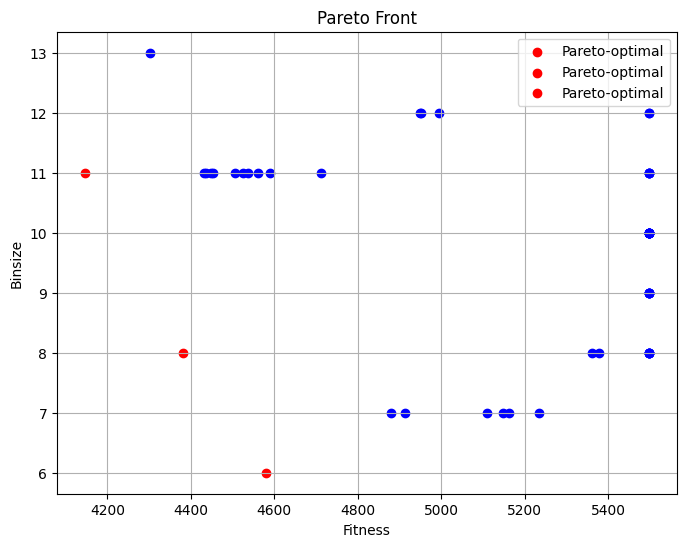

In [15]:

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for bin in bin_pop:
    fitness = bin.fitness
    binsize = bin.bin_size
    dominated = False
    
    for other_bin in bin_pop:
        if (other_bin.fitness < fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness <= fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness < fitness and other_bin.bin_size <= binsize):
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        plt.scatter(fitness, binsize, color='blue')

# Add labels and title
plt.xlabel('Fitness')
plt.ylabel('Binsize')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [16]:
pop_df = fibers.set.report_pop()

print(pop_df)
max_bin_size = pop_df['Bin Size:'].max()
print(max_bin_size)
object_list = pop_df[['Fitness','Bin Size']]

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Sort objects based on fitness (to be maximized) and binsize (to be minimized)
sorted_objects = sorted(object_list, key=lambda x: (x['fitness'], -x['binsize']))

# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for i, obj in enumerate(sorted_objects):
    fitness = obj['fitness']
    binsize = obj['binsize']
    dominated = False
    
    for other_obj in sorted_objects[i + 1:]:
        if other_obj['fitness'] > fitness and other_obj['binsize'] < binsize:
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        break

# Draw a line representing the non-dominated front
plt.plot(pareto_fitness, pareto_binsize, color='green', linestyle='-', linewidth=2, label='Non-dominated front')

# Add labels and title
plt.xlabel('Fitness (Maximize)')
plt.ylabel('Binsize (Minimize)')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

                                         feature_list  group_threshold  \
0           [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]                1   
1           [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9]                0   
2   [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
3      [P_1, P_2, P_3, P_4, P_5, P_7, P_8, P_9, R_27]                1   
4           [P_1, P_10, P_4, P_5, P_6, P_7, P_8, P_9]                1   
5   [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
6     [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9, R_57]                1   
7   [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_8,...                3   
8     [P_1, P_10, P_2, P_5, P_6, P_7, P_8, P_9, R_12]                1   
9     [P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9, R_60]                1   
10  [P_1, P_10, P_2, P_3, P_5, P_6, P_7, P_8, P_9,...                1   
11  [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
12  [P_1, P_10, P_2, P_3, P_4, P_5, P_

TypeError: 'NoneType' object is not subscriptable